# Preparing the Data

In [3]:
from utils.prepare_database import DataPreparer

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
faq_doc_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
local_file = r"C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\travel2.sqlite"
backup_file = r"C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\travel2.backup.sqlite"
v_db_file = r"C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\chroma_langchain_db"

data_preparer = DataPreparer(verbose=True)
data_preparer.prepare_all()

Trying to request and download database from URL...
DB saved to C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\travel2.sqlite
DB copied to C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\travel2.backup.sqlite
DB connection established to C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\travel2.sqlite
Bookings table, timestamps shifted by 102 days 05:49:15.065818 days
Flights table, timestamps shifted by 102 days 05:49:15.065818 days
All timestamp changes overwritten to DB: C:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\database\travel2.sqlite
Existing vectorstore loaded successfully with type: VectorStore
Retriever instantiated = 'similarity: 2'
All preparation steps completed successfully.


## Observe what we have downloaded

In [4]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(local_file)
cursor = conn.cursor()

# sqlite_master: The Schema Table
sql_query = """SELECT name FROM
sqlite_master
WHERE type='table';
"""

tables = pd.read_sql(sql_query, conn)['name'].to_list()
tables

['aircrafts_data',
 'airports_data',
 'boarding_passes',
 'bookings',
 'flights',
 'seats',
 'ticket_flights',
 'tickets',
 'car_rentals',
 'hotels',
 'trip_recommendations']

In [6]:
# Lets dive deep on tables
# But first, make dataframe all of them

table_dataframes = {}
for table in tables:
    table_dataframes[table] = pd.read_sql_query(f"SELECT * FROM {table}", conn)

# for example
table_dataframes['flights'].head()

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,QR0051,2024-09-05 02:42:16.963917-04:00,2024-09-05 07:47:16.963917-04:00,BSL,BKK,Scheduled,319,None,None
1,3979,MU0066,2024-08-20 07:42:16.963917-04:00,2024-08-20 10:27:16.963917-04:00,SHA,CUN,Scheduled,CR2,None,None
2,4739,QF0126,2024-08-31 05:22:16.963917-04:00,2024-08-31 07:07:16.963917-04:00,SHA,AMS,Scheduled,763,None,None
3,5502,LX0136,2024-09-07 02:42:16.963917-04:00,2024-09-07 04:12:16.963917-04:00,OSL,PRG,Scheduled,763,None,None
4,6938,IB0075,2024-08-30 05:17:16.963917-04:00,2024-08-30 06:12:16.963917-04:00,OSL,RGN,Scheduled,SU9,None,None


In [7]:
# lets observe all the tables:
for table_name, table in table_dataframes.items():
    print(f"Table Name: {table_name}")
    print(F"Total Records: {len(table)}\n")
    print(table.head())
    print("-"*100, "\n")

Table Name: aircrafts_data
Total Records: 9

  aircraft_code                model  range
0           773       Boeing 777-300  11100
1           763       Boeing 767-300   7900
2           SU9  Sukhoi Superjet-100   3000
3           320      Airbus A320-200   5700
4           321      Airbus A321-200   5600
---------------------------------------------------------------------------------------------------- 

Table Name: airports_data
Total Records: 115

  airport_code                                      airport_name         city  \
0          ATL  Hartsfield-Jackson Atlanta International Airport      Atlanta   
1          PEK             Beijing Capital International Airport      Beijing   
2          DXB                       Dubai International Airport        Dubai   
3          LAX                 Los Angeles International Airport  Los Angeles   
4          HND                              Tokyo Haneda Airport        Tokyo   

            coordinates             timezone  
0   [33.

# Try Using VectorDatabase

In [1]:
from utils.prepare_database import DataPreparer

retriever = DataPreparer().start_retriever()

In [2]:
query = "How can i change my flight?"
retrieved_content = retriever.invoke(query)
retrieved_content

[Document(page_content='## Booking and Cancellation\n\n1. How can I change my booking?\n\t* The ticket number must start with 724 (SWISS ticket no./plate).\n\t* The ticket was not paid for by barter or voucher (there are exceptions to voucher payments; if the ticket was paid for in full by voucher, then it may be possible to rebook online under certain circumstances. If it is not possible to rebook online because of the payment method, then you will be informed accordingly during the rebooking process).\n\t* There must be an active flight booking for your ticket. It is not possible to rebook open tickets or tickets without the corresponding flight segments online at the moment.\n\t* It is currently only possible to rebook outbound (one-way) tickets or return tickets with single flight routes (point-to-point).\n2. Which tickets/bookings cannot be rebooked online currently?\n\t* Bookings containing flight segments with other airlines\n\t* Bookings containing reservations, where a ticket 

In [2]:
from tools.lookup_policy import lookup_policy

query = "How can i change my flight?"
policy = lookup_policy(query)
policy

c:\Users\fcali\OneDrive\Masaüstü\DATA_SCIENCE\LLMs\TRAVEL_ASSISTANT_MULTI_AGENT\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'## Booking and Cancellation\n\n1. How can I change my booking?\n\t* The ticket number must start with 724 (SWISS ticket no./plate).\n\t* The ticket was not paid for by barter or voucher (there are exceptions to voucher payments; if the ticket was paid for in full by voucher, then it may be possible to rebook online under certain circumstances. If it is not possible to rebook online because of the payment method, then you will be informed accordingly during the rebooking process).\n\t* There must be an active flight booking for your ticket. It is not possible to rebook open tickets or tickets without the corresponding flight segments online at the moment.\n\t* It is currently only possible to rebook outbound (one-way) tickets or return tickets with single flight routes (point-to-point).\n2. Which tickets/bookings cannot be rebooked online currently?\n\t* Bookings containing flight segments with other airlines\n\t* Bookings containing reservations, where a ticket has not yet been issued

# Graphs

## Zero Shot Agent

In [1]:
from _zero_shot_agent.graph import build_graph_zero_shot

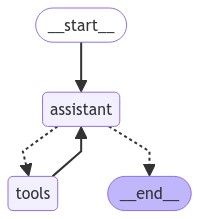

In [2]:
graph = build_graph_zero_shot()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
import uuid
from tools.helpers import _print_event
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
question = "Hi there, what time is my flight?"

events = graph.stream(
    {"messages": ("user", question)}, config, stream_mode="values"
)

configuration = config.get("configurable", {})
passenger_id = configuration.get("passenger_id", None)

print(f"Bu bir log kaydidir:.Passenger_id...{passenger_id}")
print(f"configuration:.....{configuration}")
for event in events:
    _print_event(event, _printed)

Bu bir log kaydidir:.Passenger_id...3442 587242
configuration:.....{'passenger_id': '3442 587242', 'thread_id': '30f312b0-6395-4078-9529-cef44bd078e0'}
================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_twH7BUNQLnJXCbGtl0CEz506)
 Call ID: call_twH7BUNQLnJXCbGtl0CEz506
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

Error: ValueError('No passenger ID configured.')
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_Tl4CuwRyUzMthdLtsHmM2Frt)
 Call ID: call_Tl4CuwRyUzMthdLtsHmM2Frt
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

Error: Val

In [4]:
event

{'messages': [HumanMessage(content='Hi there, what time is my flight?', id='51e8952c-d10f-473c-b3bf-5308279fd040'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_twH7BUNQLnJXCbGtl0CEz506', 'function': {'arguments': '{}', 'name': 'fetch_user_flight_information'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 1710, 'total_tokens': 1723}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-15c80627-d40f-4696-947f-a15e9e4e57d4-0', tool_calls=[{'name': 'fetch_user_flight_information', 'args': {}, 'id': 'call_twH7BUNQLnJXCbGtl0CEz506', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1710, 'output_tokens': 13, 'total_tokens': 1723}),
  ToolMessage(content="Error: ValueError('No passenger ID configured.')\n Please fix your mistakes.", name='fetch_user_flight_information', id='ff78fa4e-f21c-4a89-99d2-fbba535cc312', tool_call_i